In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from datetime import datetime, timedelta
import seaborn as sns

import datetime
from dateutil.parser import parse

import numpy as np


from matplotlib import rcParams

from scipy.stats import chi2_contingency

plt.rcParams["figure.figsize"] = (20,10)
# %reset

In [2]:
pip install scikit-posthocs


In [186]:
from scipy import stats
import scikit_posthocs as sp
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
# Setup and Import data
from statsmodels.tsa.stattools import adfuller

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [6]:
import glob

all_files = glob.glob("./Duo_Auth*.csv")

li = []

for filename in all_files:
#     print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

C:\Users\Francisco\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'])
df['date'] = df['Timestamp (UTC)'].apply(lambda timestamp: timestamp.date())
df['month'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.month)
df['hour'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.hour)
df['minute'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.minute)
df['second'] = df['Timestamp (UTC)'].apply(lambda timestamp:  timestamp.second)

In [8]:
logs = df
print(logs.shape)
logs.head(2)

(7077783, 16)


,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10


In [9]:
users = pd.read_csv('duo_users_clean.csv')
users['Created'] = users['Created'].apply(lambda date: parse(date))
users.head()

,Alias,Status,Created,Last Login,Phone 1 platform,Phone 2 platform,Phone 3 platform,Phone 4 platform,Phone 5 platform,Phone 6 platform,Phone 7 platform,Student,Description,Index
0,user_000001,Active,2017-04-26 18:31:00,4/7/2021 15:00,Landline,NaN,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),1
1,user_000002,Active,2017-04-26 18:58:00,4/6/2021 21:34,Android,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),2
2,user_000003,Active,2017-04-27 20:42:00,4/6/2021 16:35,Landline,Android,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),3
3,user_000004,Active,2017-08-16 17:10:00,4/7/2021 14:23,iOS,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),4
4,user_000005,Active,2017-09-12 22:03:00,4/7/2021 0:17,Android,Landline,NaN,NaN,NaN,NaN,NaN,False,Active (Staff),5


In [10]:
# Get a list of users who have logged in
usersWhoHaveLoggedIn = logs.Alias.unique()

In [11]:
subsetOfUsers = users[users['Alias'].isin(usersWhoHaveLoggedIn)]
len(subsetOfUsers)

50962

In [12]:
subsetOfUsers['Description'].fillna("", inplace=True)

C:\Users\Francisco\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [13]:
subsetOfUsers = subsetOfUsers[~subsetOfUsers["Description"].str.contains("Disabled")]
subsetOfUsers = subsetOfUsers[~subsetOfUsers["Description"].str.contains("DISABLED")]

In [14]:
subsetOfUsers.Description.value_counts()

Active (Student)                                                32931
Active (Formerstudent)                                           6685
Active (Student, Applicant)                                      4319
Active (Faculty)                                                 1773
Active (Staff)                                                   1179
Active (Applicant)                                                750
Active (Applicant, Formerstudent)                                 371
Active (Student, Volunteer)                                       276
Active (Staff, Student)                                           201
Active (Faculty, Poi)                                             171
Active (Faculty, Emeritus)                                        152
Active (Faculty, Staff)                                           147
Active (Student, Asi)                                             146
Active (Emeritus)                                                 131
Active (Uei)        

In [15]:
mask1 = subsetOfUsers["Description"]=="Active (Student)"
mask2 = subsetOfUsers["Description"]=="Active (Faculty)"
mask3 = subsetOfUsers["Description"]=="Active (Staff)"

In [16]:
subsetOfUsers = subsetOfUsers[(mask1) | (mask2) | (mask3)]
subsetOfUsers.shape

(35883, 14)

In [17]:
logs.shape

(7077783, 16)

In [18]:
logs = logs[logs['Alias'].isin(subsetOfUsers.set_index("Alias")["Description"].to_dict())]
logs.shape

(6130032, 16)

In [19]:
logs = logs[logs.month!=5]

In [ ]:
# Determine if the number of users that experince failures per day is stationary

In [91]:
failedLogins = logs[logs["Result"]=="FAILURE"]

In [26]:
failedLoginsByDay = failedLogins.groupby(["Alias","date"]).size()

In [27]:
failedLoginsByDay = failedLoginsByDay.reset_index()

In [28]:
uniqueFailedUsersPerDay = failedLoginsByDay.groupby(["date"]).size()

In [32]:
result = adfuller(uniqueFailedUsersPerDay, autolag='AIC')

In [33]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.006339425028
p-value: 0.03430660398470878
Critial Values:
   1%, -3.470126426071447
Critial Values:
   5%, -2.8790075987120027
Critial Values:
   10%, -2.5760826967621644


In [ ]:
# p value is less than .05 so we reject the null hypothesis, the data does not have a unit root and is stationary. This means
# that the number of users that experinces errors every day is not increaseing or decreasing over time

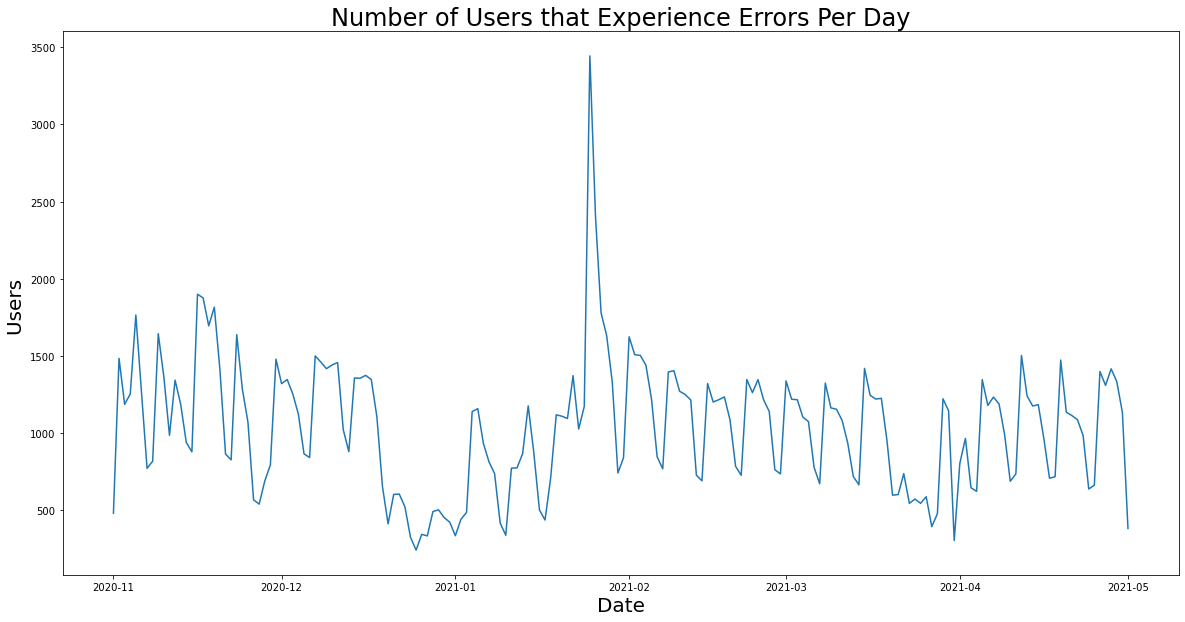

In [35]:
uniqueFailedUsersPerDay.plot(figsize=(20,10))
plt.ylabel('Users ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number of Users that Experience Errors Per Day', fontsize=24)
plt.show()

In [ ]:
# Determine if the error Rate by month is stationary 

In [67]:
failedLoginsByMonth = failedLogins.groupby(["month"]).size()

In [68]:
failedLoginsByMonthRearranged = failedLoginsByMonth.reindex([11,12,1,2,3,4,5])

In [73]:
failedLoginsByMonthRearranged.drop([5], inplace=True)

In [74]:
failedLoginsByMonthRearranged

month
11    57298
12    42738
1     52240
2     47489
3     41964
4     46608
dtype: int64

In [78]:
failedLoginsByMonthRearranged = failedLoginsByMonthRearranged.rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})

In [81]:
resultOfFailedLoginsPerMonth = adfuller(failedLoginsByMonthRearranged, autolag='AIC')

In [82]:
print(f'ADF Statistic: {resultOfFailedLoginsPerMonth[0]}')
print(f'p-value: {resultOfFailedLoginsPerMonth[1]}')
for key, value in resultOfFailedLoginsPerMonth[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.391237051186632
p-value: 0.00030761347361887186
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681


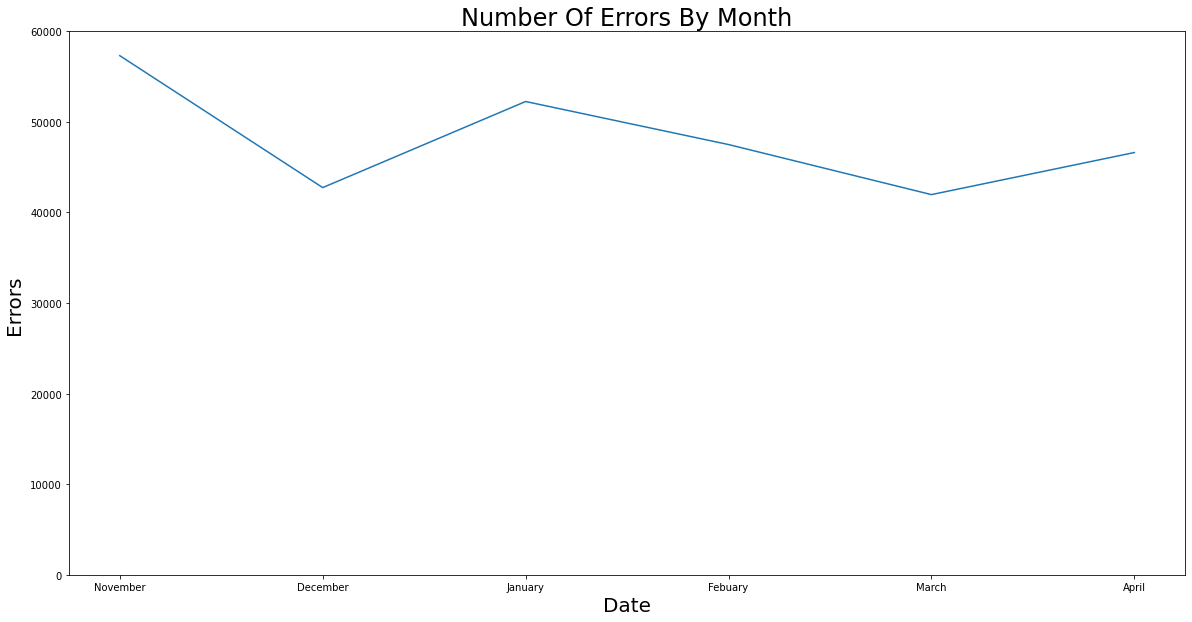

In [85]:
failedLoginsByMonthRearranged.plot()
plt.ylim(0,60000)

plt.ylabel('Errors ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number Of Errors By Month', fontsize=24)
plt.show()

In [ ]:
# Compare the number of type of errors that occur

In [35]:
users_logs_by_month = logs[(logs['month']!=5) & (logs['Result']=="FAILURE")][["month","Result","Reason"]]

In [214]:
users_logs_by_month.head()

,month,Result,Reason
10,4,FAILURE,No response
14,4,FAILURE,No response
33,4,FAILURE,User cancelled
68,4,FAILURE,No response
84,4,FAILURE,User cancelled


In [37]:
users_logs_by_month.Reason.value_counts()/6

User cancelled      22327.833333
No response         20783.000000
Invalid passcode     2612.000000
No keys pressed       985.500000
Call timed out        762.166667
User mistake          478.666667
Locked out             99.166667
Error                   4.833333
Invalid device          1.833333
User is disabled        1.166667
Name: Reason, dtype: float64

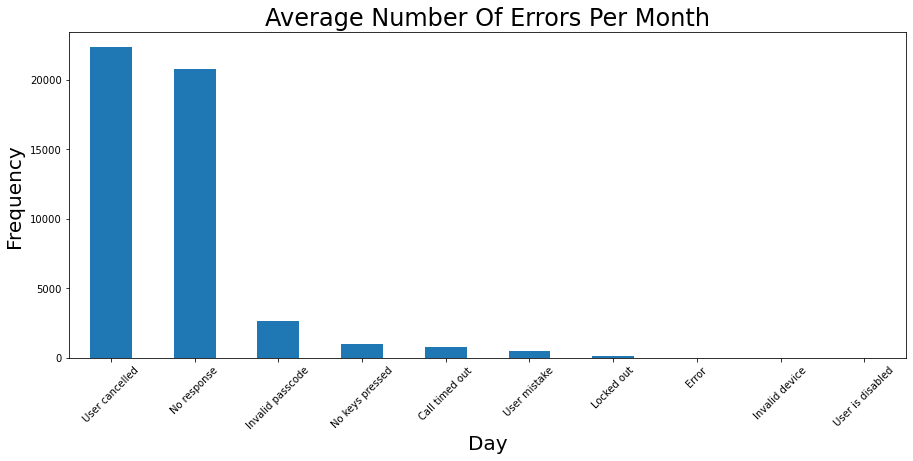

In [38]:
rcParams['figure.figsize'] = 15,6
(users_logs_by_month.Reason.value_counts()/6).plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Frequency ', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.title('Average Number Of Errors Per Month', fontsize=24)
plt.show()

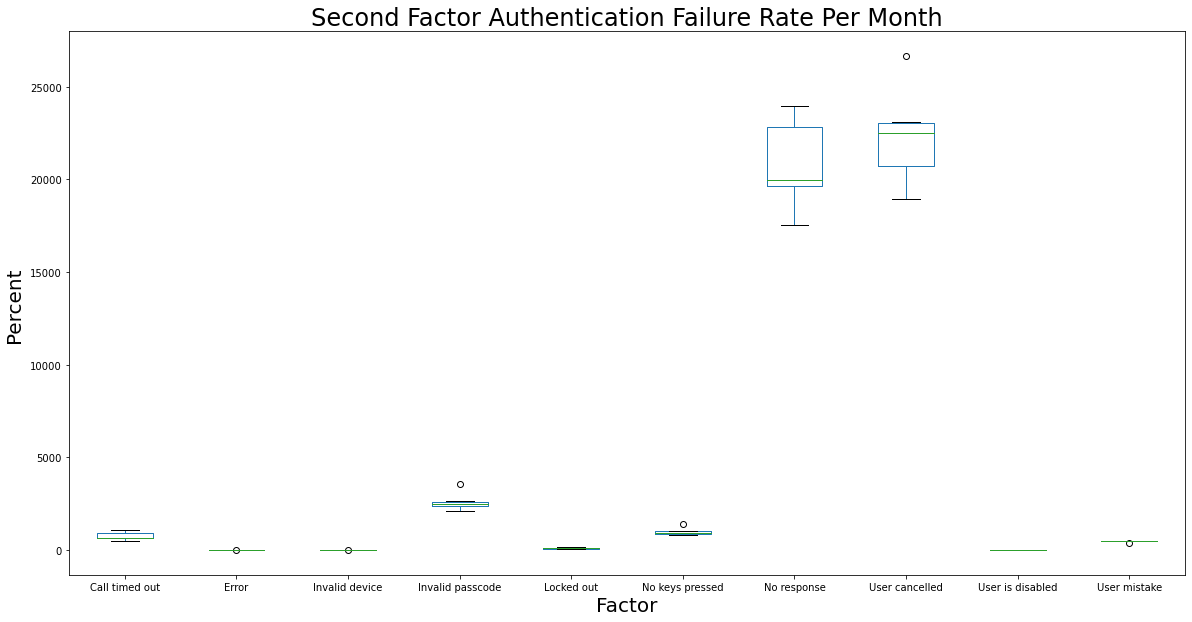

In [28]:
users_logs_by_month.groupby(['month', 'Reason']).size().unstack(level=1).fillna(0).boxplot(grid=False)
plt.ylabel('Percent ', fontsize=20)
plt.xlabel('Factor', fontsize=20)
plt.title('Second Factor Authentication Failure Rate Per Month', fontsize=24)
plt.show()

In [39]:
users_logs_by_month_errors = users_logs_by_month.groupby(['month', 'Reason']).size().unstack(level=1).fillna(0)

In [40]:
users_logs_by_month_errors.columns

Index(['Call timed out', 'Error', 'Invalid device', 'Invalid passcode',
       'Locked out', 'No keys pressed', 'No response', 'User cancelled',
       'User is disabled', 'User mistake'],
      dtype='object', name='Reason')

In [41]:
stats.kruskal(users_logs_by_month_errors['Call timed out'], 
              users_logs_by_month_errors['Invalid passcode'],
              users_logs_by_month_errors['No keys pressed'], 
              users_logs_by_month_errors['No response'],
              users_logs_by_month_errors['User cancelled'],
              users_logs_by_month_errors['User mistake'])

KruskalResult(statistic=31.99622382423619, pvalue=5.951498358220317e-06)

In [57]:
month_error_groups = [users_logs_by_month_errors['No response'],
                      users_logs_by_month_errors['User cancelled'],
                      users_logs_by_month_errors['Call timed out'], 
                      users_logs_by_month_errors['Invalid passcode'],
                      users_logs_by_month_errors['No keys pressed'], 
                      users_logs_by_month_errors['User mistake']]
sp.posthoc_dunn(month_error_groups, p_adjust = 'bonferroni')

,1,2,3,4,5,6
1,1.000000,1.000000,0.026763,1.000000,0.138489,0.000366
2,1.000000,1.000000,0.010181,1.000000,0.060154,0.000105
3,0.026763,0.010181,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,0.060154
5,0.138489,0.060154,1.000000,1.000000,1.000000,1.000000
6,0.000366,0.000105,1.000000,0.060154,1.000000,1.000000


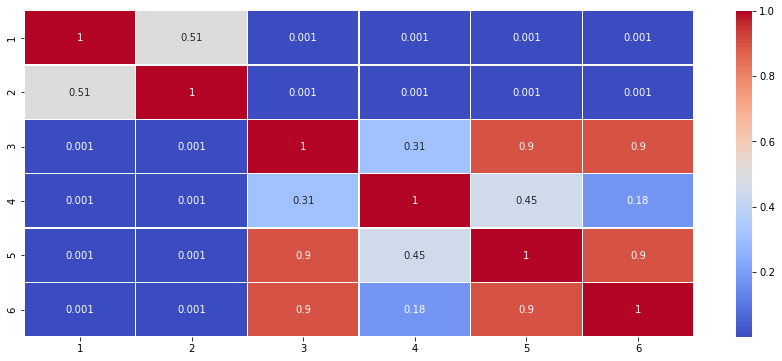

In [56]:
sns.heatmap(sp.posthoc_tukey(month_error_groups),cmap='coolwarm', linewidths = 0.30, annot = True)
plt.show()

In [ ]:
# Compute the average number of errors that occur throughout the week

In [89]:
logs["Day"] = logs["date"].apply(lambda date: date.strftime('%a'))

<ipython-input-89-8212a08c5e6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs["Day"] = logs["date"].apply(lambda date: date.strftime('%a'))


In [146]:
failedLoginsByTimeOfDay = failedLogins.groupby(["Day", "hour"]).size().unstack(level=0)

In [114]:
failuresOutsideIRTServiceHours = 0
failuresWithinIRTServiceHours = 0
for idx, val  in enumerate(failedLoginsByTimeOfDay.sum(axis=1)):
    if(idx<=8 or idx>=17):
#         print(val)
        failuresOutsideIRTServiceHours += val
    else:
        failuresWithinIRTServiceHours += val
        
print('percent of errors outside of IRT service hours')
print(failuresOutsideIRTServiceHours / (failuresWithinIRTServiceHours + failuresOutsideIRTServiceHours)*100)

percent of errors outside of IRT service hours
86.32692554012746


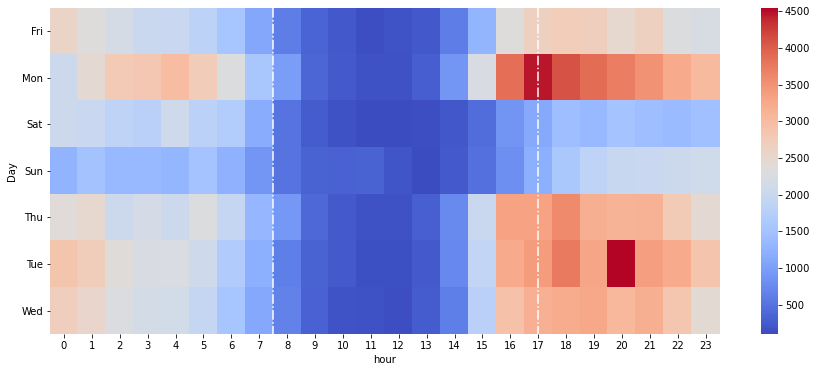

In [115]:
df_m = failedLoginsByTimeOfDay
df_m = df_m.fillna(0)
rcParams['figure.figsize'] = 15,6
ax = sns.heatmap(df_m.transpose(), cmap='coolwarm')
# plt.xticks(rotation=45)
ax.vlines([8,17.5],*ax.get_xlim(), color='white', linestyle='dashdot')
plt.yticks(rotation=0)
# plt.xticks(rotation=80)
plt.show()
plt.rcParams["figure.figsize"] = (20,50)

In [153]:
failedAverageLoginsByDay = failedLoginsByTimeOfDay.sum()/24
failedAverageLoginsByDay

Day
Fri    1640.666667
Mon    2288.750000
Sat    1123.750000
Sun    1109.041667
Thu    1944.125000
Tue    2067.083333
Wed    1862.708333
dtype: float64

In [154]:
failedLoginsByDay = failedAverageLoginsByDay.reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

In [155]:
resultOfFailedLoginsByDay= adfuller(failedLoginsByDay, autolag='AIC')

In [156]:
print(f'ADF Statistic: {resultOfFailedLoginsByDay[0]}')
print(f'p-value: {resultOfFailedLoginsByDay[1]}')
for key, value in resultOfFailedLoginsByDay[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.4013164490412419
p-value: 0.909878745368705
Critial Values:
   1%, -5.354256481481482
Critial Values:
   5%, -3.6462381481481483
Critial Values:
   10%, -2.901197777777778


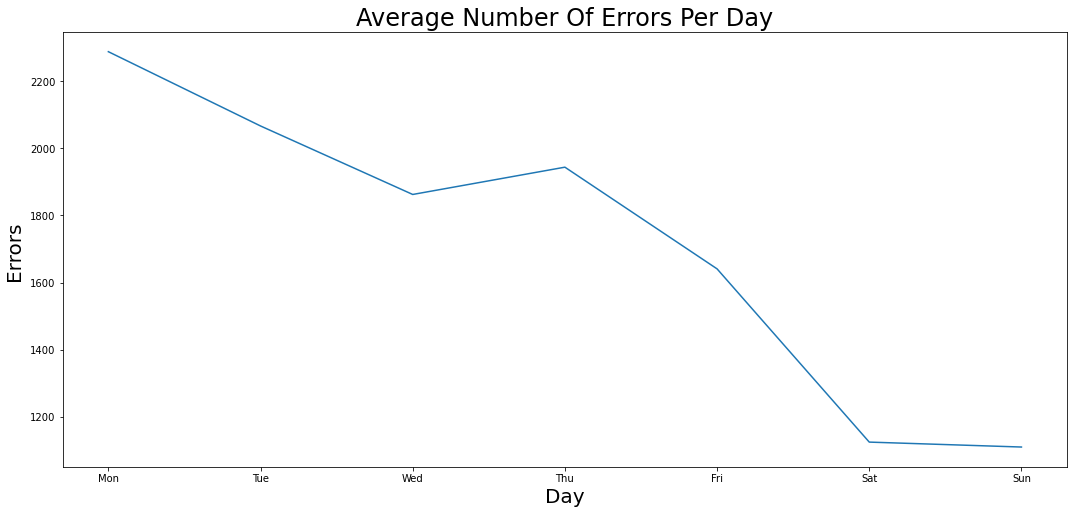

In [157]:
failedLoginsByDay.plot(figsize=(18, 8))
plt.ylabel('Errors ', fontsize=20)
plt.xlabel('Day', fontsize=20)
plt.title('Average Number Of Errors Per Day', fontsize=24)
plt.show()

In [ ]:
# compute the error rate of the population

In [59]:
userErrorRate = logs[['Alias','Result','Reason']].groupby(['Alias','Result']).size().reset_index(name='counts')

In [60]:
userQuantifiedLogs = userErrorRate.pivot(index='Alias',columns='Result',values='counts').drop(columns=['FRAUD'])

In [61]:
userQuantifiedLogs['FAILURE'] = userQuantifiedLogs['FAILURE'].fillna(0)

In [62]:
userQuantifiedLogs['SUCCESS'] = userQuantifiedLogs['SUCCESS'].fillna(0)

In [63]:
userQuantifiedLogs['failureRate'] = userQuantifiedLogs['FAILURE'] / (userQuantifiedLogs['SUCCESS'] + userQuantifiedLogs['FAILURE'])

In [64]:
userQuantifiedLogs.sort_values(by='failureRate', inplace=True)

In [65]:
userQuantifiedLogs.insert(0,'New_ID', range(1, len(userQuantifiedLogs)+1))

In [66]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate
Alias,,,,
user_035709,1,0.0,98.0,0.0
user_029741,2,0.0,289.0,0.0
user_031721,3,0.0,88.0,0.0
user_010406,4,0.0,218.0,0.0
user_046676,5,0.0,121.0,0.0


In [67]:
userQuantifiedLogs['userPercentage'] = userQuantifiedLogs['New_ID'].apply(lambda num: num/len(userQuantifiedLogs))

In [68]:
a = userQuantifiedLogs[['failureRate']].groupby('failureRate').size().to_frame('frequency')

In [69]:
a['CF']  = (a.frequency.cumsum() / userQuantifiedLogs.shape[0])*100

In [70]:
a.reset_index(inplace=True)

In [71]:
a["failureRate"] = a["failureRate"]*100

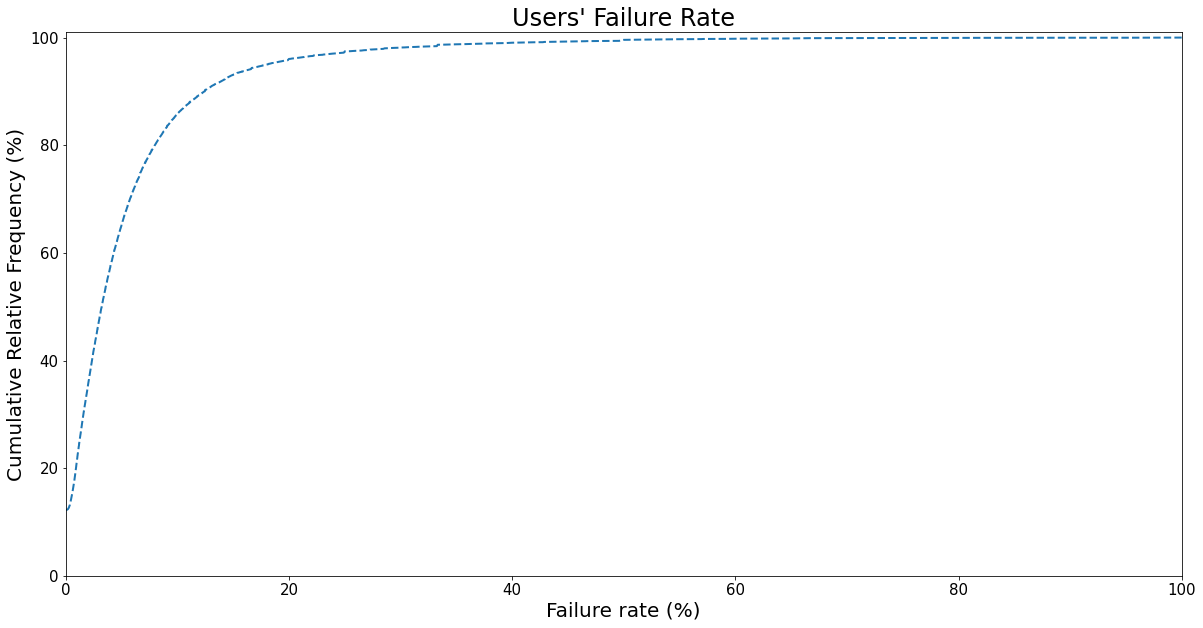

In [72]:
plt.rcParams["figure.figsize"] = (20,10)
ax = a.plot(x='failureRate', y='CF', legend=False, ls = '--', lw = 2,)
plt.ylabel('Cumulative Relative Frequency (%)', fontsize=20)
plt.xlabel('Failure rate (%)', fontsize=20)
plt.xlim(0,100)
plt.title("Users' Failure Rate", fontsize=24)


plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.ylim(0,101)

plt.savefig('failureRates.png')
plt.show()

In [73]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage
Alias,,,,,
user_035709,1,0.0,98.0,0.0,0.000028
user_029741,2,0.0,289.0,0.0,0.000056
user_031721,3,0.0,88.0,0.0,0.000084
user_010406,4,0.0,218.0,0.0,0.000111
user_046676,5,0.0,121.0,0.0,0.000139


In [74]:
userQuantifiedLogs['loginTimes'] = userQuantifiedLogs['SUCCESS'] + userQuantifiedLogs['FAILURE']

In [77]:
userQuantifiedLogs['quartile'] = userQuantifiedLogs['userPercentage'].apply(lambda num: quartileRange(num))

In [76]:
def quartileRange(num):
    if(num<=.25):
        return "first_quartile"
    elif(num>.25 and num <.75):
        return "inter_quartile"
    elif(num>=.75):
        return "third_quartile"

In [78]:
userQuantifiedLogs['failureRate'].describe()

count    35883.000000
mean         0.054584
std          0.076036
min          0.000000
25%          0.012346
50%          0.032258
75%          0.067258
max          1.000000
Name: failureRate, dtype: float64

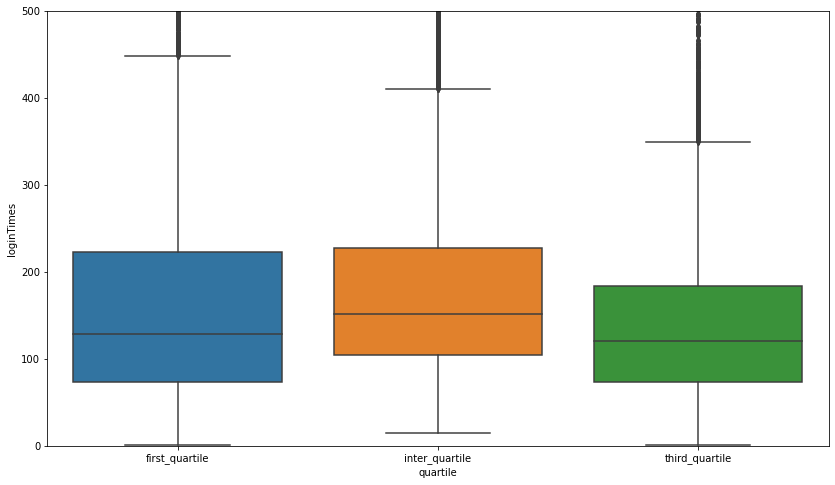

In [79]:
plt.rcParams["figure.figsize"] = (14,8)
sns.boxplot(x="quartile", y="loginTimes", data=userQuantifiedLogs)
plt.ylim(0,500)
plt.show()

In [82]:
userQuantifiedLogs.head()

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description
Alias,,,,,,,,
user_035709,1,0.0,98.0,0.0,0.000028,98.0,first_quartile,Active (Student)
user_029741,2,0.0,289.0,0.0,0.000056,289.0,first_quartile,Active (Student)
user_031721,3,0.0,88.0,0.0,0.000084,88.0,first_quartile,Active (Student)
user_010406,4,0.0,218.0,0.0,0.000111,218.0,first_quartile,Active (Student)
user_046676,5,0.0,121.0,0.0,0.000139,121.0,first_quartile,Active (Student)


<AxesSubplot:xlabel='failureRate', ylabel='loginTimes'>

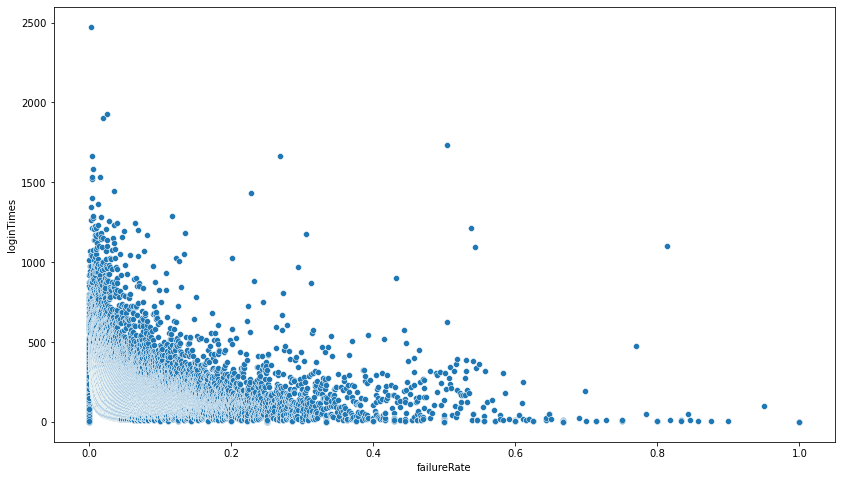

In [83]:
sns.scatterplot(data=userQuantifiedLogs, x="failureRate", y="loginTimes")

In [80]:
userQuantifiedLogs["Description"] = userQuantifiedLogs.index.map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

In [97]:
userQuantifiedLogs.head(1)

Result,New_ID,FAILURE,SUCCESS,failureRate,userPercentage,loginTimes,quartile,Description
Alias,,,,,,,,
user_035709,1,0.0,98.0,0.0,0.000028,98.0,first_quartile,Active (Student)


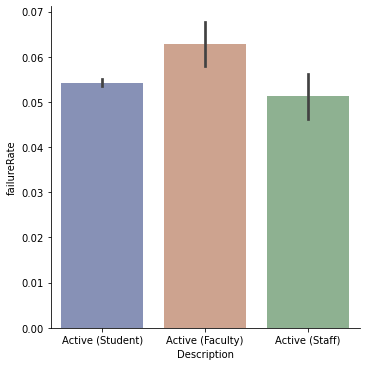

In [213]:
sns.catplot(
    data=userQuantifiedLogs, kind="bar",
    x="Description", y="failureRate", palette="dark", alpha=.5, height=5
)
plt.show()

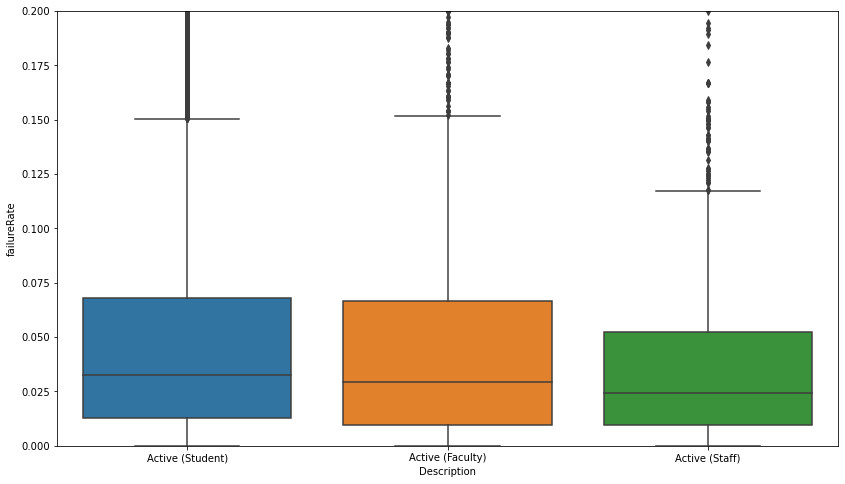

In [212]:
plt.rcParams["figure.figsize"] = (14,8)
sns.boxplot(x="Description", y="failureRate", data=userQuantifiedLogs)
# userQuantifiedLogs[['Description','failureRate']].boxplot(grid=False)
plt.ylim(0,.2)
plt.show()

In [99]:
groupStudents = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Student)']['failureRate']
groupStaff = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Staff)']['failureRate']
groupFaculty = userQuantifiedLogs[userQuantifiedLogs['Description']=='Active (Faculty)']['failureRate']

In [100]:
stats.kruskal(groupStudents, groupStaff, groupFaculty)

KruskalResult(statistic=43.53998412128433, pvalue=3.5108524431859926e-10)

In [101]:
groupData = [groupStudents, groupStaff, groupFaculty]

In [201]:
sp.posthoc_dunn(groupData)

,1,2,3
1,1.000000e+00,3.402927e-10,0.022036
2,3.402927e-10,1.000000e+00,0.000526
3,2.203557e-02,5.259759e-04,1.000000


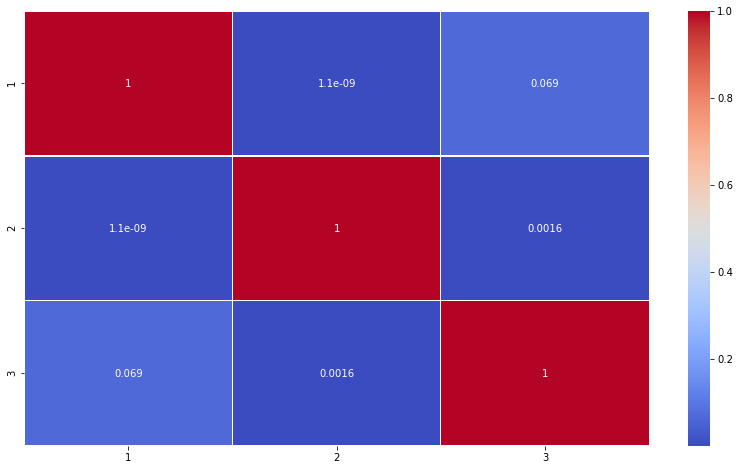

In [364]:
sns.heatmap(sp.posthoc_dunn(groupData, p_adjust = 'bonferroni'),cmap='coolwarm', linewidths = 0.30, annot = True)
plt.show()

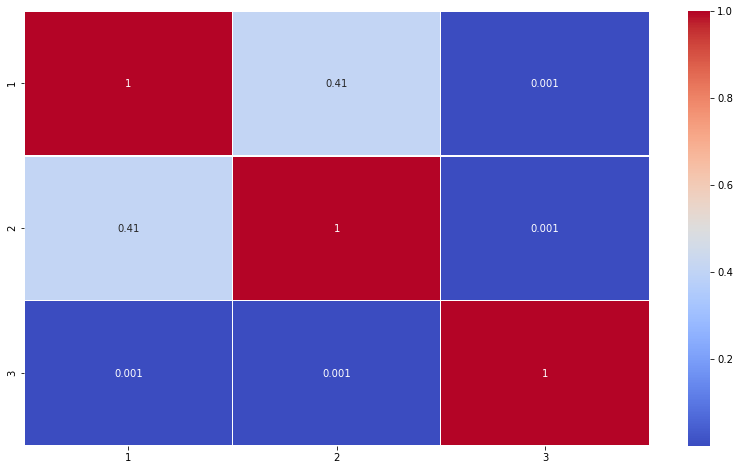

In [102]:
sns.heatmap(sp.posthoc_tukey(groupData),cmap='coolwarm', linewidths = 0.30, annot = True)
plt.show()
# student, staff, faculty

In [ ]:
# compare error rate by authentication method

In [167]:
modifiedLogs = logs

In [168]:
def modifyFactor(factor):
    if(factor=='Bypass Code' or factor=='Duo Mobile Passcode' or factor=='Hardware Token' or factor=='Yubikey Passcode'):
        return 'Passcode'
    elif(factor=='U2F Token' or factor=='Security Key (WebAuthn)'):
        return 'Security Key'
    else:
        return factor

In [169]:
modifiedLogs['Factor'] = modifiedLogs['Factor'].apply(lambda factor: modifyFactor(factor))

In [170]:
modifiedLogs['Factor'].value_counts()

Duo Push               3768967
Remembered Device      1125084
Phone Call              719088
Passcode                318187
Touch ID (WebAuthn)      19764
Security Key             17934
Bypass Status             2487
Name: Factor, dtype: int64

In [171]:
authLogsByMonth = modifiedLogs.groupby(['month','Factor','Result']).size().unstack(level=2).fillna(0)
authLogsByMonth.head()

Result                   FAILURE  FRAUD   SUCCESS
month Factor                                     
1     Bypass Status          0.0    0.0     462.0
      Duo Push           21304.0   17.0  552141.0
      Passcode            2627.0    0.0   46071.0
      Phone Call          5048.0    0.0  109401.0
      Remembered Device      0.0    0.0  163239.0

In [172]:
authLogsByMonth['failureRate'] = authLogsByMonth['FAILURE'] / (authLogsByMonth['FAILURE'] + authLogsByMonth['SUCCESS'])

In [173]:
authLogsByMonthFailureRate = authLogsByMonth.drop(columns=['FAILURE','FRAUD','SUCCESS'])

In [174]:
authLogsByMonthFailureRate = authLogsByMonthFailureRate.unstack(level=1).fillna(0)

In [175]:
authLogsByMonthFailureRate.columns = authLogsByMonthFailureRate.columns.droplevel()

In [176]:
authLogsByMonthFailureRate.drop(columns=['Bypass Status','Remembered Device'], inplace=True)

In [177]:
authLogsByMonthFailureRate

Factor,Duo Push,Passcode,Phone Call,Security Key,Touch ID (WebAuthn)
month,,,,,
1,0.037151,0.053945,0.044107,0.0,0.0
2,0.025590,0.044874,0.034366,0.0,0.0
3,0.025404,0.043678,0.034587,0.0,0.0
4,0.025415,0.046220,0.034078,0.0,0.0
11,0.030477,0.055065,0.048031,0.0,0.0
12,0.033336,0.050569,0.037521,0.0,0.0


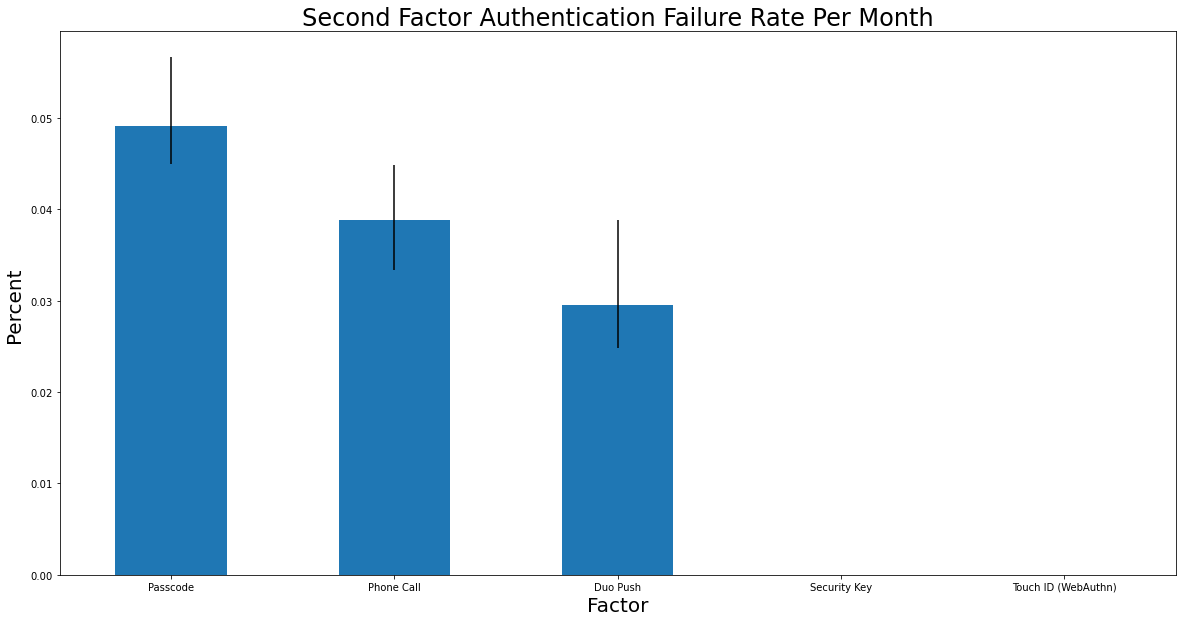

In [187]:
authLogsByMonthFailureRate.mean().sort_values(ascending=False).plot.bar(rot=0, yerr=[authLogsByMonthFailureRate.mean()-authLogsByMonthFailureRate.min(), authLogsByMonthFailureRate.max()-authLogsByMonthFailureRate.mean()])
plt.ylabel('Percent ', fontsize=20)
plt.xlabel('Factor', fontsize=20)
plt.title('Second Factor Authentication Failure Rate Per Month', fontsize=24)
plt.show()

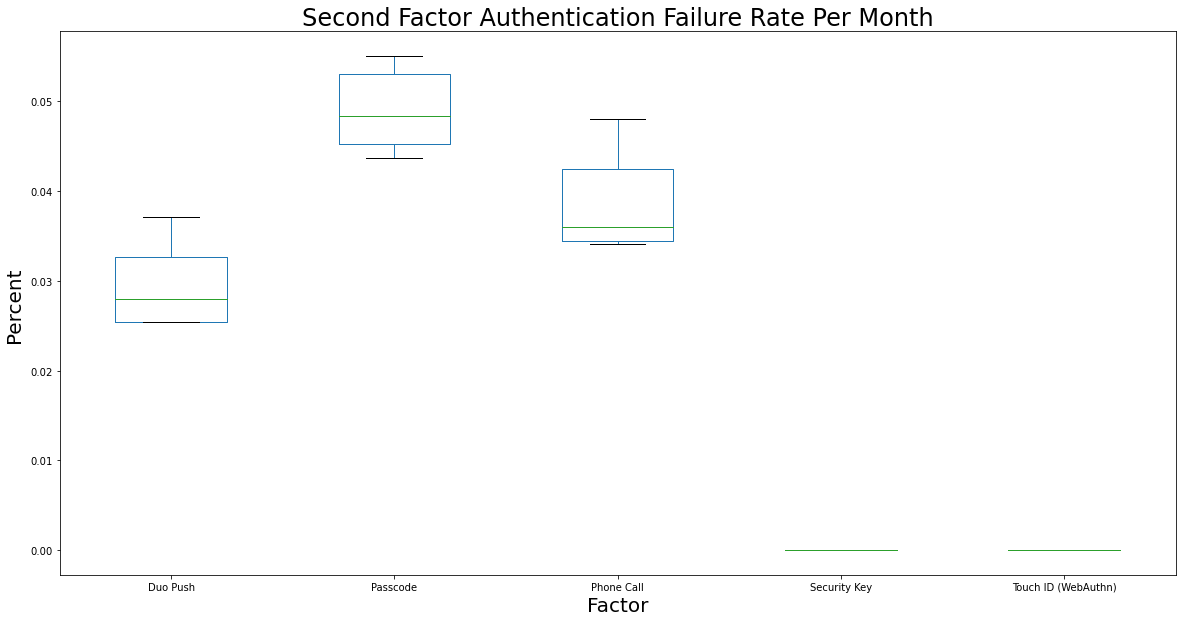

In [188]:
authLogsByMonthFailureRate.boxplot(grid=False)
plt.ylabel('Percent ', fontsize=20)
plt.xlabel('Factor', fontsize=20)
plt.title('Second Factor Authentication Failure Rate Per Month', fontsize=24)
plt.show()

In [181]:
stats.kruskal(authLogsByMonthFailureRate['Duo Push'], 
              authLogsByMonthFailureRate['Passcode'],
              authLogsByMonthFailureRate['Phone Call'],
              authLogsByMonthFailureRate['Security Key'],
              authLogsByMonthFailureRate['Touch ID (WebAuthn)'])

KruskalResult(statistic=27.17874396135266, pvalue=1.8291416285905837e-05)

In [182]:
data = [authLogsByMonthFailureRate['Duo Push'], 
              authLogsByMonthFailureRate['Passcode'],
              authLogsByMonthFailureRate['Phone Call'],
              authLogsByMonthFailureRate['Security Key'],
              authLogsByMonthFailureRate['Touch ID (WebAuthn)']]

In [184]:
sp.posthoc_dunn(data)

,1,2,3,4,5
1,1.000000,0.027619,0.249255,0.053414,0.053414
2,0.027619,1.000000,0.293489,0.000036,0.000036
3,0.249255,0.293489,1.000000,0.002044,0.002044
4,0.053414,0.000036,0.002044,1.000000,1.000000
5,0.053414,0.000036,0.002044,1.000000,1.000000


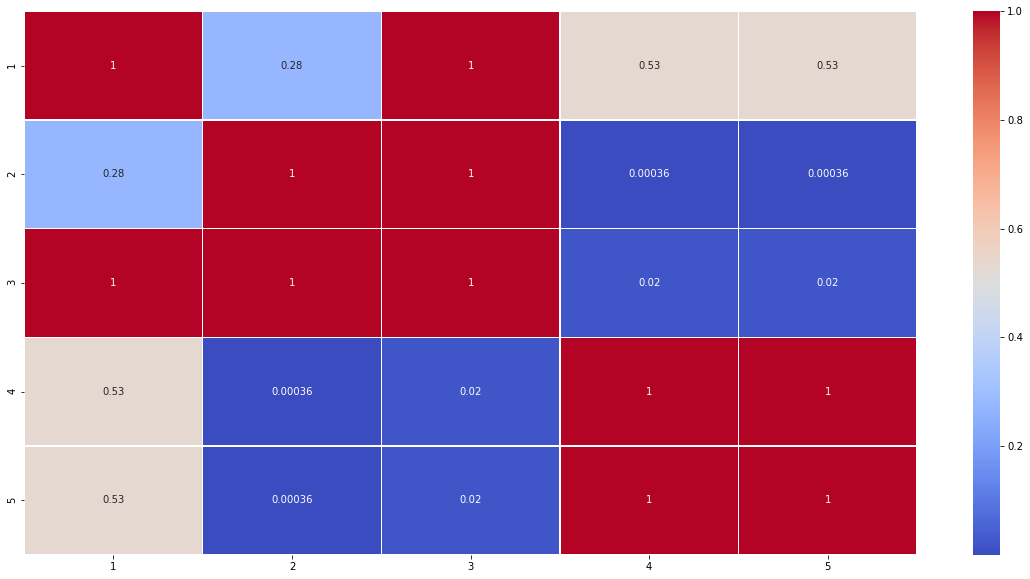

In [196]:
sns.heatmap(sp.posthoc_dunn(data, p_adjust="bonferroni"),cmap='coolwarm', linewidths = 0.30, annot = True)
plt.show()
# bonerroni correction is .0055

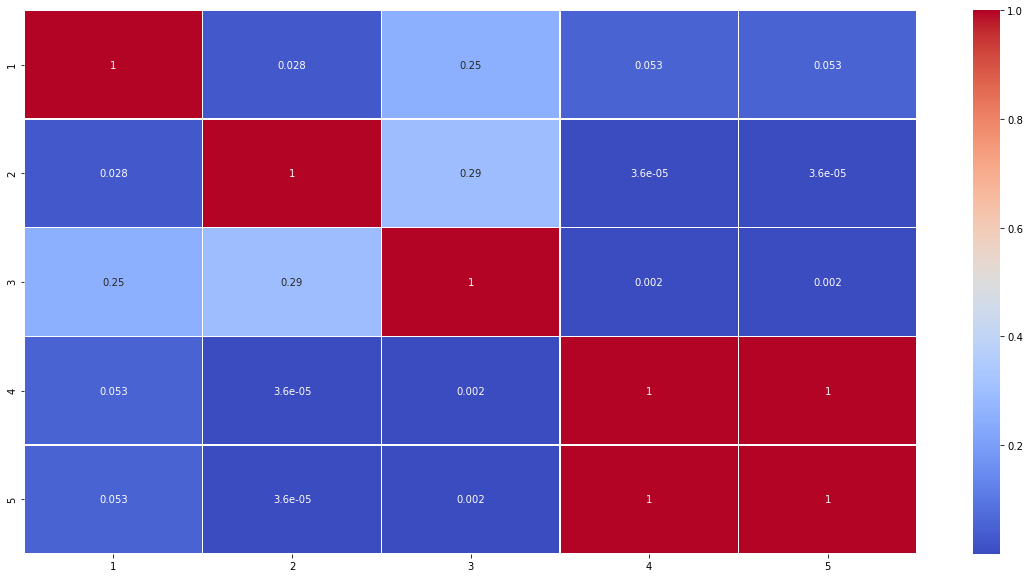

In [197]:
sns.heatmap(sp.posthoc_dunn(data),cmap='coolwarm', linewidths = 0.30, annot = True)
plt.show()
# bonerroni correction is .0055

In [ ]:
# Compare the usage of second factors by group

In [369]:
usageOfSecondFactorLogs = logs

In [370]:
usageOfSecondFactorLogs["Description"] = usageOfSecondFactorLogs['Alias'].map(subsetOfUsers.set_index("Alias")["Description"].to_dict())

<ipython-input-370-3445250fef56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usageOfSecondFactorLogs["Description"] = usageOfSecondFactorLogs['Alias'].map(subsetOfUsers.set_index("Alias")["Description"].to_dict())


In [374]:
factorsBeingUsed = usageOfSecondFactorLogs[['Factor','Description','Reason','Alias']]
factorsBeingUsed.head()

,Factor,Description,Reason,Alias
0,Phone Call,Active (Student),User approved,user_008576
1,Duo Push,Active (Student),User approved,user_049277
3,Duo Push,Active (Student),User approved,user_025756
4,Duo Push,Active (Student),User approved,user_030286
5,Duo Push,Active (Student),User approved,user_019093


In [395]:
t = factorsBeingUsed.groupby(['Description','Factor','Alias']).count()

In [396]:
t.head(50)

Reason
Description      Factor        Alias              
Active (Faculty) Bypass Status user_002555     183
                               user_003242       2
                               user_003282      17
                               user_003287     419
                 Duo Push      user_000105     402
                               user_000107     323
                               user_000113     192
                               user_000115     648
                               user_000116     158
                               user_000121      75
                               user_000122     321
                               user_000125     471
                               user_000128     448
                               user_000131     468
                               user_000135      84
                               user_000146     335
                               user_000149     122
                               user_000165      42
                               user_000168      91
                               user_000188     266
                               user_000253     249
                               user_000270      50
                               user_000352      10
                               user_000417      64
                               user_000495      13
                               user_000498     187
                               user_000567     244
                               user_000583     126
                               user_000601     235
                               user_000602     115
                               user_000603     355
                               user_000614     161
                               user_000623     313
                               user_000624     135
                               user_000626      49
                               user_000642     189
                               user_000644     190
                               user_000646     375
                               user_000651     439
                               user_000660     101
                               user_000686     110
                               user_000688       7
                               user_000701       4
                               user_000719     600
                               user_000743     255
                               user_000806     144
                               user_000808     237
                               user_000833     124
                               user_000837     321
                               user_000840      44

In [401]:
t = factorsBeingUsed.groupby(['Description','Factor','Alias']).count().unstack(level=2).count(axis=1).reset_index()

In [411]:
factorsBeingUsedByGroup = factorsBeingUsed.groupby(['Description','Factor','Alias']).count().unstack(level=2).count(axis=1).unstack(level=1).fillna(0)

In [413]:
factorsBeingUsedByGroup

Factor,Bypass Status,Duo Push,Passcode,Phone Call,Remembered Device,Security Key,Touch ID (WebAuthn)
Description,,,,,,,
Active (Faculty),4.0,1282.0,573.0,730.0,1029.0,90.0,4.0
Active (Staff),0.0,810.0,476.0,537.0,811.0,34.0,2.0
Active (Student),18.0,28873.0,8719.0,12878.0,18183.0,11.0,361.0


In [514]:
# run chi squared test


In [515]:
totalFaculty = 1773
totalStaff = 1179
totalStudents = 32931
def createFactorDataFrame(factor):  
    d = { factor + ' Enabled': factorsBeingUsedByGroup[factor]}
    factorUsers = pd.DataFrame(data=d)
    factorUsers[factor+' Not Enabled'] = [totalFaculty  - factorUsers[factor+' Enabled'][0],
                                          totalStaff    - factorUsers[factor+' Enabled'][1],
                                          totalStudents - factorUsers[factor+' Enabled'][2]]
    return factorUsers.transpose()

In [568]:
factors = factorsBeingUsedByGroup.columns
for factor in factors:
    if(factor!="Bypass Status"):
        factorUsageDataFrame = createFactorDataFrame(factor)
        print(factorUsageDataFrame)
        print(factor)
        print(chi2_contingency(factorUsageDataFrame))
        print('')
        computePairWiseChiSquared(factorUsageDataFrame)
        print('')

Description           Active (Faculty)  Active (Staff)  Active (Student)
Duo Push Enabled                1282.0           810.0           28873.0
Duo Push Not Enabled             491.0           369.0            4058.0
Duo Push
(655.0538136757496, 5.713098153219391e-143, 2, array([[ 1529.99874592,  1017.41033358, 28417.59092049],
       [  243.00125408,   161.58966642,  4513.40907951]]))

Faculty VS Staff
False
////////////////
Faculty VS Student
True
////////////////
Staff VS Student
True

Description           Active (Faculty)  Active (Staff)  Active (Student)
Passcode Enabled                 573.0           476.0            8719.0
Passcode Not Enabled            1200.0           703.0           24212.0
Passcode
(135.40422939049918, 3.956809800162018e-30, 2, array([[  482.64258841,   320.94507148,  8964.41234011],
       [ 1290.35741159,   858.05492852, 23966.58765989]]))

Faculty VS Staff
True
////////////////
Faculty VS Student
True
////////////////
Staff VS Student
True

Descripti

In [32]:
def computePairWiseChiSquared(dataFrame):
    pVal = .016
    print("Faculty VS Staff")
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']]))
    print("////////////////")
    print("Faculty VS Student")
    print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']]))
    print("////////////////")
    print("Staff VS Student")
    print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']])[1]<pVal)
#     print(chi2_contingency(dataFrame[['Active (Staff)','Active (Student)']]))

In [ ]:
# p value is .01
# Conclusion is that students are more likley to use Duo push authentcation compared to faculty and staff

In [498]:
# percentagesOfDuoPushUsers = (duoPushUsers.transpose()["Duo Push Enabled"] / (duoPushUsers.transpose()["Duo Push Enabled"] + duoPushUsers.transpose()["Duo Push Not Enabled"]))*100

In [499]:
# percentagesOfDuoPushUsers.plot.bar()

In [ ]:
# Determine if the usage of second factors over time is stationary

In [570]:
logFactorsOverTime = logs

In [574]:
logFactorsOverTime.head()

,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second,Description
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7,Active (Student)
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10,Active (Student)
3,2021-04-01 07:00:25.203564+00:00,user_025756,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Lodi,NaN,2021-04-01,4,7,0,25,Active (Student)
4,2021-04-01 07:00:27.389194+00:00,user_030286,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Antioch,NaN,2021-04-01,4,7,0,27,Active (Student)
5,2021-04-01 07:00:30.814923+00:00,user_019093,Single Sign-On,Duo Push,SUCCESS,User approved,False,PH,Metro Manila,Pasig,NaN,2021-04-01,4,7,0,30,Active (Student)


In [578]:
logFactorsOverTime.groupby(['month','Factor']).size().unstack()

Factor,Bypass Status,Duo Push,Passcode,Phone Call,Remembered Device,Security Key,Touch ID (WebAuthn)
month,,,,,,,
1,462,573462,48698,114449,163239,2737,3065
2,454,685134,55511,131844,208977,3305,3627
3,447,605309,48629,118483,179256,3167,3285
4,474,687033,51515,133840,220139,3385,3700
5,1,7070,432,1401,2404,13,48
11,342,690756,65069,122046,204621,2713,3403
12,308,527273,48765,98426,148852,2627,2684


In [88]:
logs_by_factor = logs

In [89]:
logs_by_factor.head()

,Timestamp (UTC),Alias,Integration,Factor,Result,Reason,Enrollment,Access Device Country,Access Device State,Access Device City,Access Device Hostname,date,month,hour,minute,second
0,2021-04-01 07:00:07.957411+00:00,user_008576,Single Sign-On,Phone Call,SUCCESS,User approved,False,US,California,Rocklin,NaN,2021-04-01,4,7,0,7
1,2021-04-01 07:00:10.492910+00:00,user_049277,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Santa Maria,NaN,2021-04-01,4,7,0,10
3,2021-04-01 07:00:25.203564+00:00,user_025756,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Lodi,NaN,2021-04-01,4,7,0,25
4,2021-04-01 07:00:27.389194+00:00,user_030286,Single Sign-On,Duo Push,SUCCESS,User approved,False,US,California,Antioch,NaN,2021-04-01,4,7,0,27
5,2021-04-01 07:00:30.814923+00:00,user_019093,Single Sign-On,Duo Push,SUCCESS,User approved,False,PH,Metro Manila,Pasig,NaN,2021-04-01,4,7,0,30


In [90]:
logs_by_factor_users = logs_by_factor.groupby(['month','Alias','Factor']).size()

In [96]:
i = logs_by_factor_users.unstack(level=2).fillna(0)

In [107]:
i = i.applymap(lambda x: hasUsedFactor(x))

In [109]:
g = i.reset_index()

In [108]:
i.reset_index().head()

Factor,month,Alias,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode
0,1,user_000001,0,0,0,0,1,1,0,1,0,0,0,0
1,1,user_000002,0,0,0,1,0,0,0,1,0,0,1,1
2,1,user_000003,0,0,0,1,1,0,0,0,0,0,0,0
3,1,user_000004,0,0,0,1,1,1,0,0,0,0,0,0
4,1,user_000005,0,0,0,0,1,0,0,1,0,0,1,0


In [105]:
def hasUsedFactor(num):
    if(num>0):
        return 1
    else:
        return 0

In [110]:
g.head()

Factor,month,Alias,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode
0,1,user_000001,0,0,0,0,1,1,0,1,0,0,0,0
1,1,user_000002,0,0,0,1,0,0,0,1,0,0,1,1
2,1,user_000003,0,0,0,1,1,0,0,0,0,0,0,0
3,1,user_000004,0,0,0,1,1,1,0,0,0,0,0,0
4,1,user_000005,0,0,0,0,1,0,0,1,0,0,1,0


In [118]:
h = g

In [150]:
h.columns[2:]

Index(['Bypass Code', 'Bypass Status', 'Duo Mobile Passcode', 'Duo Push',
       'Hardware Token', 'Passcode', 'Phone Call', 'Remembered Device',
       'Security Key (WebAuthn)', 'Touch ID (WebAuthn)', 'U2F Token',
       'Yubikey Passcode'],
      dtype='object', name='Factor')

In [187]:
dataFramee = pd.DataFrame(columns=h.columns[2:])
dataFramee

Factor,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode


In [188]:
months = [11,12,1,2,3,4]
for i in months:
    row = []
    for j in h.columns:
        if(j!='month' and j!='Alias'):
#             print(i, j)
            d = h[h['month']==i][j].sum()
            row.append(d)
    tempDF = pd.DataFrame(data=np.array([row]),columns=h.columns[2:],index = [i])
    dataFramee = pd.concat([dataFramee, tempDF])

In [193]:
dataFrameeRanamed = dataFramee.rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})
dataFrameeRanamed

Factor,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode
November,66,17,4041,27693,613,1489,7790,15097,32,261,83,0
December,39,14,3189,27598,607,1078,7435,14275,37,252,92,0
January,40,11,3127,28495,620,1137,7949,15248,35,269,94,1
Febuary,49,11,2863,27271,607,1076,7260,15590,36,271,96,1
March,45,11,2525,26847,607,943,7239,14987,32,282,88,2
April,41,11,2575,26947,581,997,7332,15627,32,267,87,0


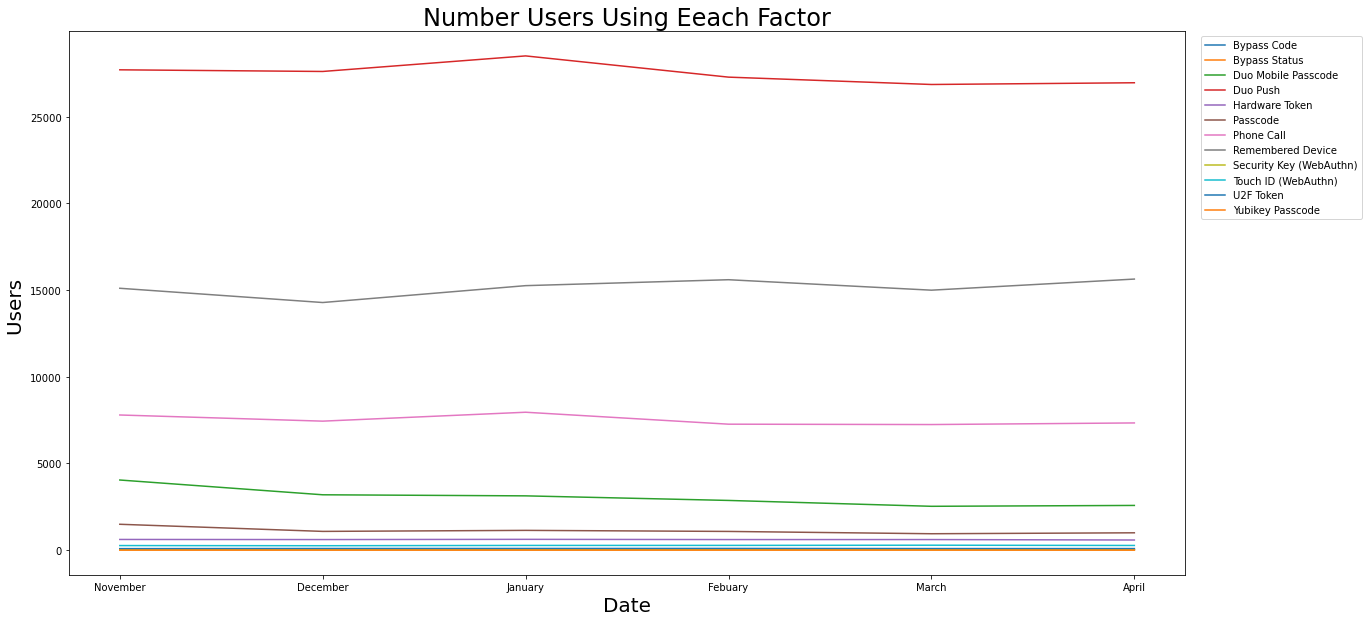

In [207]:
dataFrameeRanamed.plot()
plt.ylabel('Users ', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Number Users Using Eeach Factor', fontsize=24)
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

In [198]:
for i in dataFrameeRanamed.columns:
    print(i)
    print(dataFrameeRanamed[i])
    resultOfFactorUsage = adfuller(dataFrameeRanamed[i])
    print(f'ADF Statistic: {resultOfFactorUsage[0]}')
    print(f'p-value: {resultOfFactorUsage[1]}')
    for key, value in resultOfFactorUsage[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('')

Bypass Code
November    66
December    39
January     40
Febuary     49
March       45
April       41
Name: Bypass Code, dtype: object
ADF Statistic: -5.072606779866837
p-value: 1.5910411083921384e-05
Critial Values:
   1%, -7.355440625
Critial Values:
   5%, -4.474365000000001
Critial Values:
   10%, -3.1269325

Bypass Status
November    17
December    14
January     11
Febuary     11
March       11
April       11
Name: Bypass Status, dtype: object
ADF Statistic: -4.024922359499622
p-value: 0.0012854882033324431
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Duo Mobile Passcode
November    4041
December    3189
January     3127
Febuary     2863
March       2525
April       2575
Name: Duo Mobile Passcode, dtype: object
ADF Statistic: -0.91393998626957
p-value: 0.7833471238347087
Critial Values:
   1%, -7.355440625
Critial Values:
   5%, -4.474365000000001
Critial Values:
   10%, -3.1269325

Duo Push
November    27693
Decemb

In [199]:
pip install pymannkendall

In [202]:
import pymannkendall as mk
for i in dataFrameeRanamed.columns:
    print(dataFrameeRanamed[i])
    print(mk.original_test(dataFrameeRanamed[i]))
    print('')

November    66
December    39
January     40
Febuary     49
March       45
April       41
Name: Bypass Code, dtype: object
Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0.0, Tau=-0.06666666666666667, s=-1.0, var_s=28.333333333333332, slope=-4.0, intercept=53.0)

November    17
December    14
January     11
Febuary     11
March       11
April       11
Name: Bypass Status, dtype: object
Mann_Kendall_Test(trend='no trend', h=False, p=0.07123907236980909, z=-1.8039504672067892, Tau=-0.6, s=-9.0, var_s=19.666666666666668, slope=-1.0, intercept=13.5)

November    4041
December    3189
January     3127
Febuary     2863
March       2525
April       2575
Name: Duo Mobile Passcode, dtype: object
Mann_Kendall_Test(trend='decreasing', h=True, p=0.024170547174545254, z=-2.2544074479065386, Tau=-0.8666666666666667, s=-13.0, var_s=28.333333333333332, slope=-264.0, intercept=3655.0)

November    27693
December    27598
January     28495
Febuary     27271
March       26847
April       26947
Nam

In [78]:
logs_by_factor_arranged = logs_by_factor.groupby(['month','Factor']).size().unstack().reindex([11,12,1,2,3,4]).fillna(0).rename( index={11: 'November', 12: 'December', 1: 'January', 2: 'Febuary', 3: 'March', 4: 'April'})

In [87]:
logs_by_factor_arranged

Factor,Bypass Code,Bypass Status,Duo Mobile Passcode,Duo Push,Hardware Token,Passcode,Phone Call,Remembered Device,Security Key (WebAuthn),Touch ID (WebAuthn),U2F Token,Yubikey Passcode
month,,,,,,,,,,,,
November,240.0,342.0,49332.0,690756.0,12855.0,2642.0,122046.0,204621.0,536.0,3403.0,2177.0,0.0
December,172.0,308.0,35132.0,527273.0,11504.0,1957.0,98426.0,148852.0,444.0,2684.0,2183.0,0.0
January,140.0,462.0,34174.0,573462.0,12354.0,2029.0,114449.0,163239.0,557.0,3065.0,2180.0,1.0
Febuary,268.0,454.0,38983.0,685134.0,14302.0,1957.0,131844.0,208977.0,651.0,3627.0,2654.0,1.0
March,220.0,447.0,32669.0,605309.0,13976.0,1757.0,118483.0,179256.0,565.0,3285.0,2602.0,7.0
April,329.0,474.0,35228.0,687033.0,14034.0,1924.0,133840.0,220139.0,563.0,3700.0,2822.0,0.0


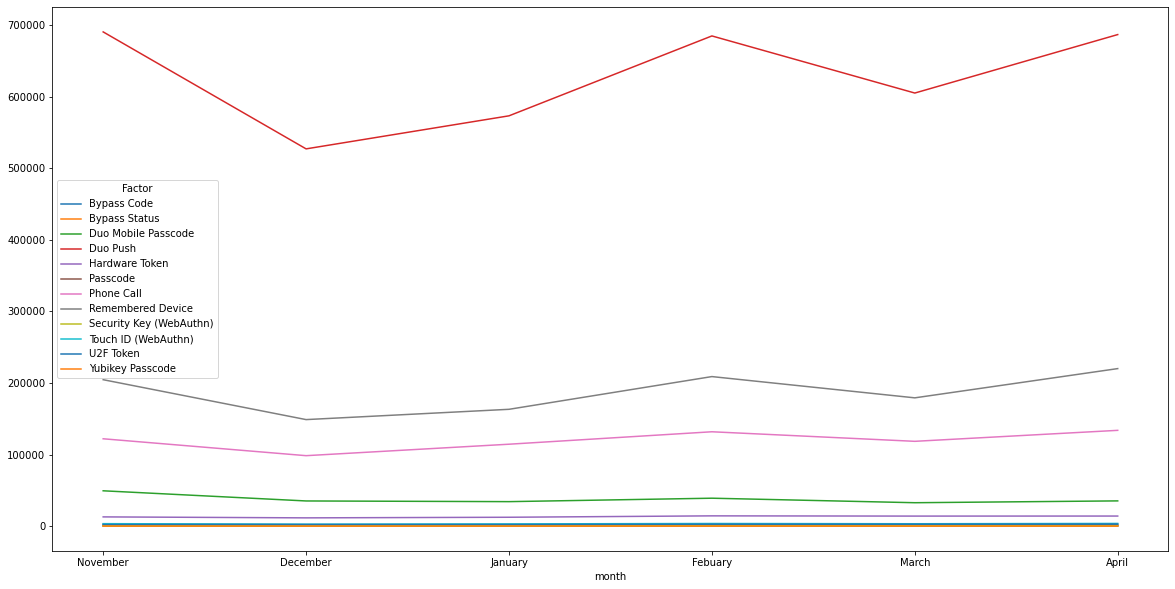

In [80]:
logs_by_factor_arranged.plot()
plt.show()

In [86]:
for i in logs_by_factor_arranged.columns:
    print(i)
    resultOfFactorUsage = adfuller(logs_by_factor_arranged[i], autolag='AIC')
    print(f'ADF Statistic: {resultOfFactorUsage[0]}')
    print(f'p-value: {resultOfFactorUsage[1]}')
    for key, value in resultOfFactorUsage[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('')

Bypass Code
ADF Statistic: -1.2569390367770126
p-value: 0.6486354533895218
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Bypass Status
ADF Statistic: -1.1869102469096628
p-value: 0.6792010947995002
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Duo Mobile Passcode
ADF Statistic: -5.56290607796308
p-value: 1.5274726892040531e-06
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Duo Push
ADF Statistic: -2.570529361979941
p-value: 0.0992424966321282
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Hardware Token
ADF Statistic: -0.9245465667027895
p-value: 0.7797814498390915
Critial Values:
   1%, -6.045114
Critial Values:
   5%, -3.9292800000000003
Critial Values:
   10%, -2.98681

Passcode
ADF Statistic: -5.525497968990551
p-value: 1.8367181293

In [20]:
# Compare the usage of enabling a backup device by group (student, faculty, staff)?

In [20]:
def enabledBackup(factor):
    if(factor!=0):
        return 1
    else:
        return 0

In [21]:
anlysisOfUsers = subsetOfUsers.fillna(0)

In [22]:
anlysisOfUsers['Backup enabled'] = anlysisOfUsers['Phone 2 platform'].apply(lambda val: enabledBackup(val))

In [23]:
anlysisOfUsers.head()

,Alias,Status,Created,Last Login,Phone 1 platform,Phone 2 platform,Phone 3 platform,Phone 4 platform,Phone 5 platform,Phone 6 platform,Phone 7 platform,Student,Description,Index,Backup enabled
0,user_000001,Active,2017-04-26 18:31:00,4/7/2021 15:00,Landline,0,0,0,0,0,0,False,Active (Staff),1,0
1,user_000002,Active,2017-04-26 18:58:00,4/6/2021 21:34,Android,Landline,0,0,0,0,0,False,Active (Staff),2,1
2,user_000003,Active,2017-04-27 20:42:00,4/6/2021 16:35,Landline,Android,0,0,0,0,0,False,Active (Staff),3,1
3,user_000004,Active,2017-08-16 17:10:00,4/7/2021 14:23,iOS,Landline,0,0,0,0,0,False,Active (Staff),4,1
4,user_000005,Active,2017-09-12 22:03:00,4/7/2021 0:17,Android,Landline,0,0,0,0,0,False,Active (Staff),5,1


In [24]:
t = anlysisOfUsers.groupby(['Description','Backup enabled']).size().unstack().transpose()

In [25]:
t

Description,Active (Faculty),Active (Staff),Active (Student)
Backup enabled,,,
0,1587,780,30785
1,186,399,2146


In [26]:
t.transpose()

Backup enabled,0,1
Description,,
Active (Faculty),1587,186
Active (Staff),780,399
Active (Student),30785,2146


In [27]:
t.transpose().sum(axis=1)

Description
Active (Faculty)     1773
Active (Staff)       1179
Active (Student)    32931
dtype: int64

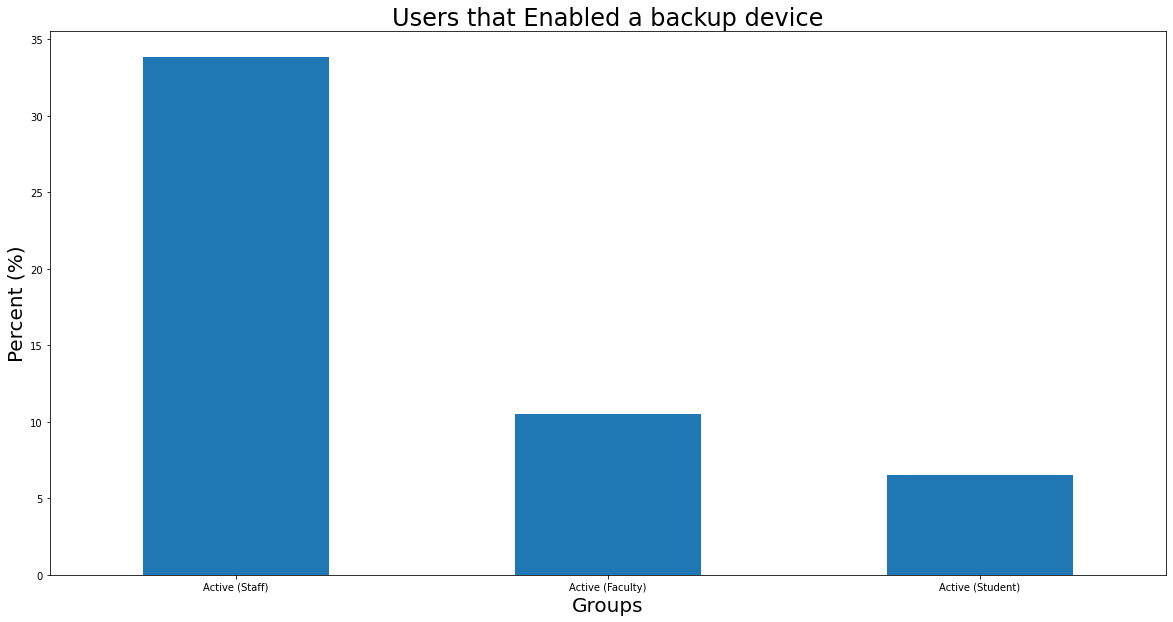

In [28]:
i = t.transpose()[1].div(t.transpose().sum(axis=1))*100
i.sort_values(ascending=False).plot.bar(rot=0)
plt.ylabel('Percent (%)', fontsize=20)
plt.xlabel('Groups', fontsize=20)
plt.title('Users that Enabled a backup device', fontsize=24)
plt.show()

In [29]:
print(chi2_contingency(t))

(1230.708398550513, 5.689404851491079e-268, 2, array([[ 1638.05969401,  1089.26812139, 30424.6721846 ],
       [  134.94030599,    89.73187861,  2506.3278154 ]]))


In [33]:
computePairWiseChiSquared(t)

Faculty VS Staff
True
////////////////
Faculty VS Student
True
////////////////
Staff VS Student
True


In [236]:
pVal = .05
print("Faculty VS Staff")
print(chi2_contingency(t[['Active (Faculty)','Active (Staff)']])[1])
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Staff)']]))
print("////////////////")
print("Faculty VS Student")
print(chi2_contingency(t[['Active (Faculty)','Active (Student)']])[1])
#     print(chi2_contingency(dataFrame[['Active (Faculty)','Active (Student)']]))
print("////////////////")
print("Staff VS Student")
print(chi2_contingency(t[['Active (Staff)','Active (Student)']])[1])

Faculty VS Staff
1.8169225917994618e-54
////////////////
Faculty VS Student
1.0330180177794038e-10
////////////////
Staff VS Student
8.226078550356733e-269


In [103]:
# determine the error rate between iphone users and android users

In [120]:
filledNanValues = subsetOfUsers.fillna(0)

In [121]:
noBackupUsers = filledNanValues[filledNanValues['Phone 2 platform']==0]

In [130]:
iosMask = noBackupUsers['Phone 1 platform']=='iOS'
androidMask = noBackupUsers['Phone 1 platform']=='Android'

In [135]:
androidAndIphoneUsers = noBackupUsers[iosMask | androidMask]

In [140]:
androidAndIphoneUsers["errorRate"] = androidAndIphoneUsers['Alias'].map(userQuantifiedLogs["failureRate"].to_dict())

<ipython-input-140-55af1dc3834e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  androidAndIphoneUsers["errorRate"] = androidAndIphoneUsers['Alias'].map(userQuantifiedLogs["failureRate"].to_dict())


In [141]:
androidAndIphoneUsers.head()

,Alias,Status,Created,Last Login,Phone 1 platform,Phone 2 platform,Phone 3 platform,Phone 4 platform,Phone 5 platform,Phone 6 platform,Phone 7 platform,Student,Description,Index,errorRate
34,user_000035,Active,2018-06-27 16:25:00,4/7/2021 15:09,iOS,0,0,0,0,0,0,False,Active (Staff),35,0.009615
44,user_000045,Active,2018-06-29 17:37:00,4/6/2021 22:27,iOS,0,0,0,0,0,0,False,Active (Staff),45,0.047945
48,user_000049,Active,2018-06-29 20:41:00,4/6/2021 20:00,iOS,0,0,0,0,0,0,False,Active (Staff),49,0.015556
52,user_000053,Active,2018-07-02 21:11:00,4/3/2021 10:22,Android,0,0,0,0,0,0,False,Active (Staff),53,0.000000
53,user_000054,Active,2018-07-03 17:27:00,4/6/2021 23:25,iOS,0,0,0,0,0,0,False,Active (Staff),54,0.052632


In [144]:
stats.ttest_ind(androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='iOS']['errorRate'], 
                androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='Android']['errorRate'])

Ttest_indResult(statistic=-3.461891881967222, pvalue=0.0005370896098907203)

In [164]:
androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='iOS']['errorRate'].mean()

0.05231436261057126

In [165]:
androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='Android']['errorRate'].mean()

0.055984905763308765

In [159]:
from scipy.stats import mannwhitneyu
res = mannwhitneyu(androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='iOS']['errorRate'], 
                androidAndIphoneUsers[androidAndIphoneUsers['Phone 1 platform']=='Android']['errorRate'])

In [160]:
res

MannwhitneyuResult(statistic=75360502.5, pvalue=1.9061873768973684e-08)

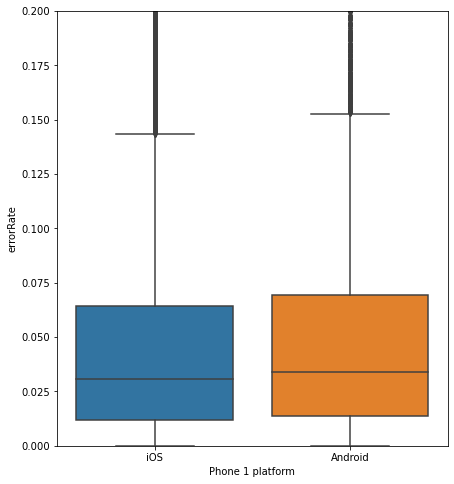

In [158]:
plt.rcParams["figure.figsize"] = (7,8)
sns.boxplot(x="Phone 1 platform", y="errorRate", data=androidAndIphoneUsers)
plt.ylim(0,.2)
plt.show()